In [1]:
import numpy as np
import pandas as pd
import pyarrow.parquet as pq

import missingno as msno
import matplotlib.pyplot as plt


In [2]:
def get_missing_data_stats(dataset):
    columns = dataset.schema.names
    null_counts = {col: 0 for col in columns}
    total_rows = 0

    for fragment in dataset.fragments:
        parquet_file = pq.ParquetFile(fragment.path)
        for i in range(parquet_file.num_row_groups):
            row_group = parquet_file.metadata.row_group(i)
            total_rows += row_group.num_rows
            for j in range(row_group.num_columns):
                col = row_group.column(j)
                col_name = col.path_in_schema
                stats = col.statistics
                if stats and stats.null_count is not None:
                    null_counts[col_name] += stats.null_count
                else:
                    # Fallback if statistics are missing
                    print("Null counts not in metadata. Loading data...")
                    return get_missing_data_fallback(dataset_path)

    null_counts_percentage  = {col: (count/total_rows) * 100 for col, count in null_counts.items()}
    return null_counts,null_counts_percentage

In [3]:
def plot_missing_data(missing_percent):
    sorted_percent = dict(sorted(missing_percent.items(), key=lambda x: -x[1]))
    non_zero_columns = {k: v for k, v in sorted_percent.items() if v > 0}
    plt.figure(figsize=(15, 8))
    plt.bar(non_zero_columns.keys(), non_zero_columns.values())
    plt.xticks(rotation=90, ha='right')
    plt.ylabel('Missing Data (%)', fontsize=18)
    plt.title('Missing Data Distribution', fontsize=2)
    plt.tight_layout()
    plt.show()

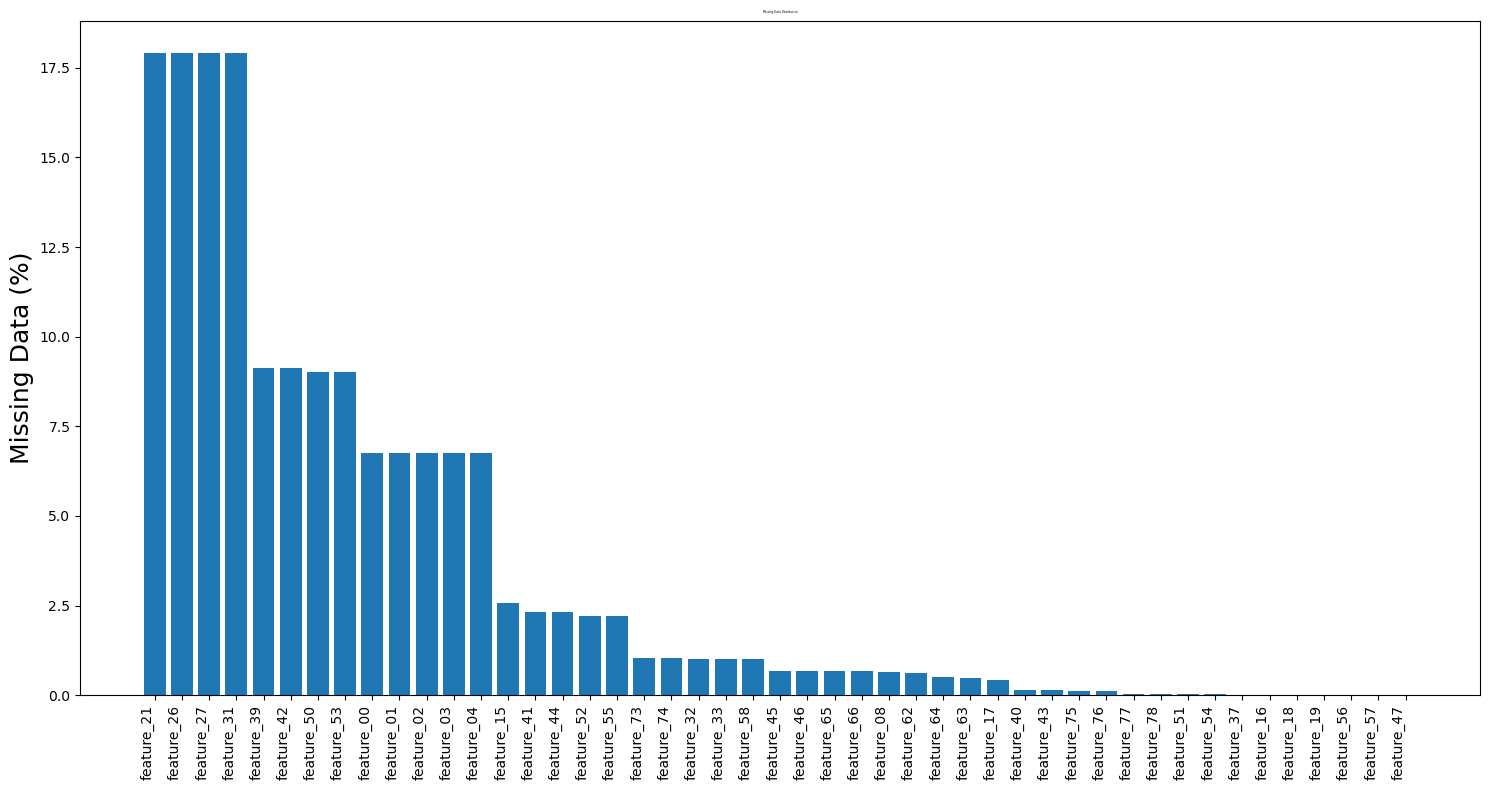

In [4]:
dataset = pq.ParquetDataset("../data/train.parquet")
_, missing_stats_percent = get_missing_data_stats(dataset)
plot_missing_data(missing_stats_percent)

In [5]:
missing_feature_percentage = len([v for v in missing_stats_percent.values() if v > 0])/len(dataset.schema.names[4:-9])
print(f"Percetage of features with missing data: {missing_feature_percentage}")

total_missing_data_percentage = (sum(missing_stats_percent.values())/(len(missing_stats_percent.keys())-14))
print(f"Percentage of total missing data: {total_missing_data_percentage}")

Percetage of features with missing data: 0.5875
Percentage of total missing data: 2.081697990455701


<Figure size 2000x1000 with 0 Axes>

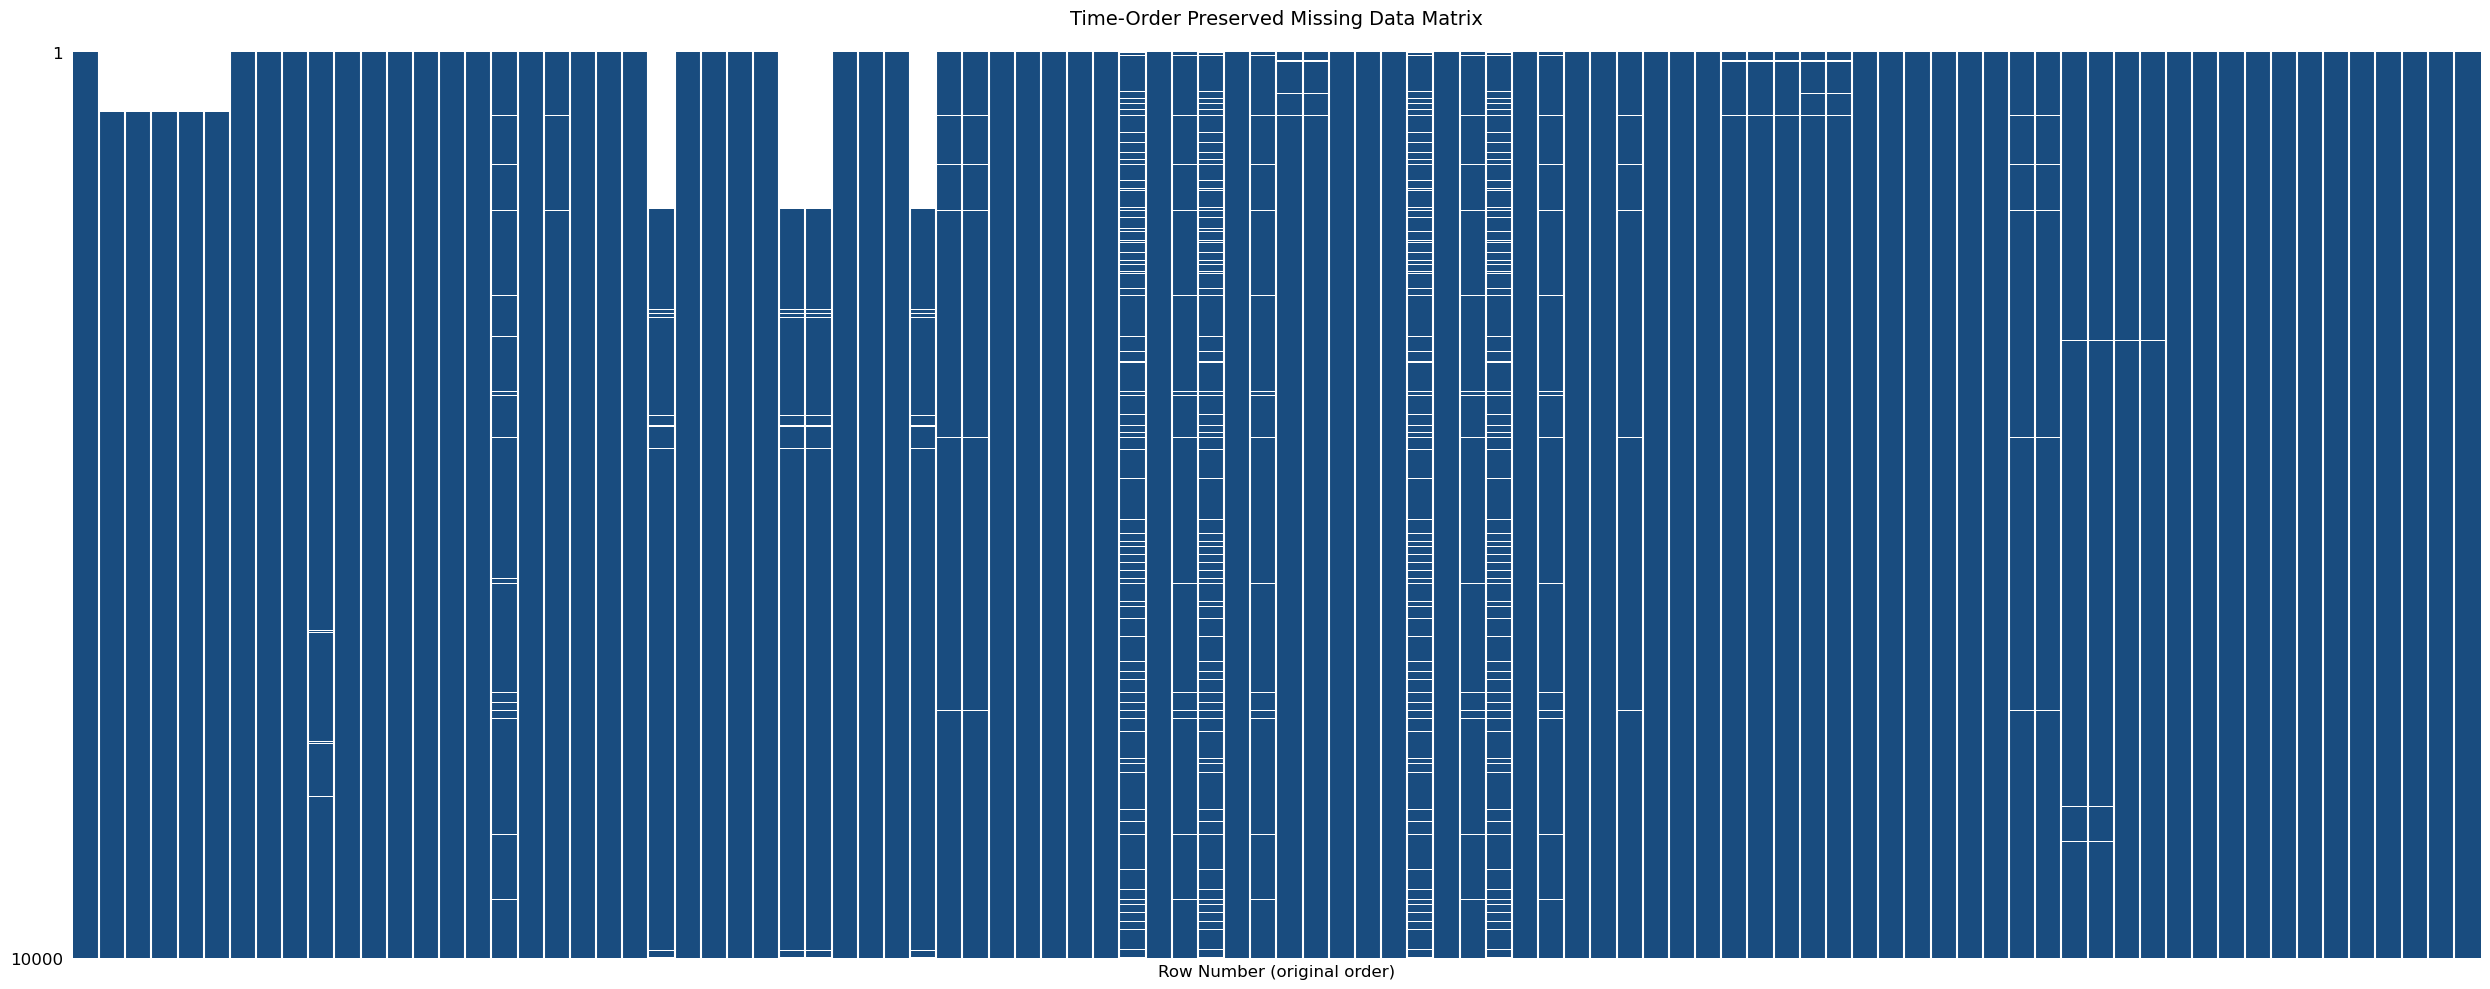

In [6]:

def ordered_parquet_sample(dataset, max_sample=10_000):
    """Stream through parquet files in order, collecting systematic sample"""
    total_rows = sum(fragment.count_rows() for fragment in dataset.fragments)
    sampling_interval = max(1, total_rows // max_sample)
    
    sampled_data = []
    current_pos = 0
    row_counter = 0

    # Stream through fragments in order
    for fragment in dataset.fragments:
        reader = pq.ParquetFile(fragment.path)
        
        # Process row groups in original order
        for rg_idx in range(reader.num_row_groups):
            rg = reader.read_row_group(rg_idx)
            rg_df = rg.to_pandas()
            rg_rows = len(rg_df)
            
            # Systematic sampling: same as every nth row
            start = (sampling_interval - (current_pos % sampling_interval)) % sampling_interval
            sample_indices = range(start, rg_rows, sampling_interval)
            
            # Preserve order within row group
            sampled_data.append(rg_df.iloc[sample_indices])
            
            current_pos += rg_rows
            row_counter += len(sample_indices)
            
            # Early exit if we have enough samples
            if row_counter >= max_sample:
                break
        
        if row_counter >= max_sample:
            break

    # Combine while preserving order
    full_sample = pd.concat(sampled_data, axis=0).iloc[:max_sample]
    return full_sample

def plot_ordered_missingno(dataset_path, sample_size=10_000):
    # Get ordered sample
    df_sample = ordered_parquet_sample(dataset_path, sample_size)
    
    # Create matrix plot with time-aware formatting
    plt.figure(figsize=(20, 10))
    msno.matrix(df_sample.sort_index(axis=1),  # Sort columns alphabetically for consistency
                sparkline=False,
                color=(0.1, 0.3, 0.5),
                fontsize=10)
    
    # Add time series specific annotations
    if df_sample.index.inferred_type == 'datetime64':
        plt.gca().xaxis.set_major_locator(plt.MaxNLocator(10))
        plt.xlabel('Timeline (sampled at regular intervals)', fontsize=12)
    else:
        plt.xlabel('Row Number (original order)', fontsize=12)
    
    plt.title('Time-Order Preserved Missing Data Matrix', pad=20, fontsize=14)
    plt.tight_layout()
    plt.show()

# Usage
plot_ordered_missingno(dataset, sample_size=10_000)

<Figure size 2000x1000 with 0 Axes>

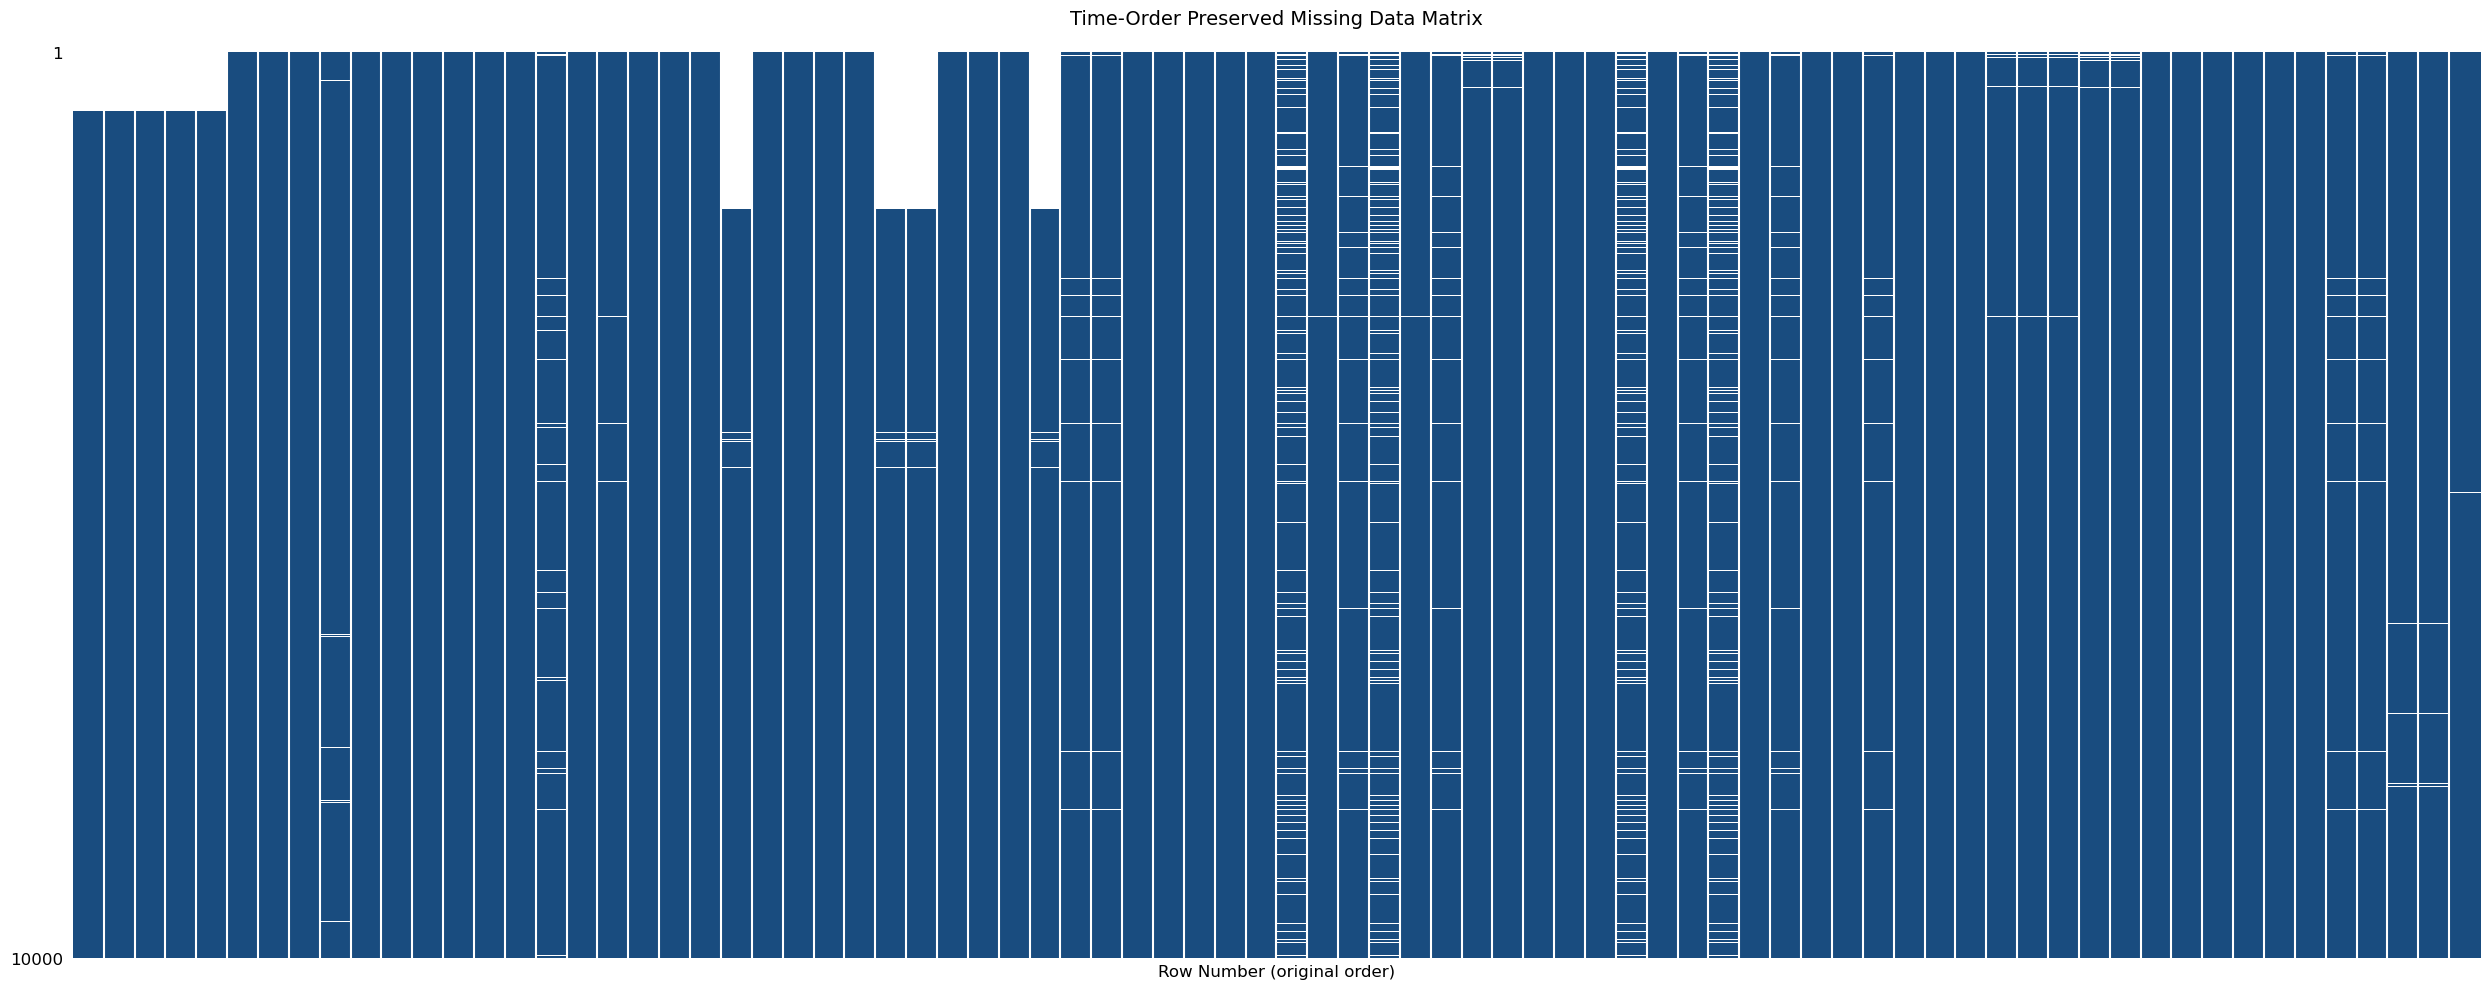

In [7]:
import numpy as np
import pandas as pd
import pyarrow.parquet as pq
import missingno as msno
import matplotlib.pyplot as plt

def ordered_parquet_sample(dataset, max_sample=10_000, start_row=0):
    """
    Systematically samples rows from a parquet dataset while preserving order.
    
    Parameters:
    - dataset: The Parquet dataset to sample from.
    - max_sample: The maximum number of rows to sample.
    - start_row: The row index where sampling begins.

    Returns:
    - DataFrame containing the sampled rows.
    """
    total_rows = sum(fragment.count_rows() for fragment in dataset.fragments)
    
    # Ensure the start_row is within bounds
    start_row = min(max(0, start_row), total_rows - 1)
    
    # Compute sampling interval to get approximately max_sample rows
    sampling_interval = max(1, (total_rows - start_row) // max_sample)
    
    sampled_data = []
    current_pos = 0  # Tracks absolute row position in the dataset
    row_counter = 0  # Counts how many rows have been sampled

    # Stream through fragments in order
    for fragment in dataset.fragments:
        reader = pq.ParquetFile(fragment.path)
        
        for rg_idx in range(reader.num_row_groups):
            rg = reader.read_row_group(rg_idx)
            rg_df = rg.to_pandas()
            rg_rows = len(rg_df)
            
            # Skip row groups until we reach the starting row
            if current_pos + rg_rows < start_row:
                current_pos += rg_rows
                continue
            
            # Systematic sampling: Take every nth row
            start = max(0, start_row - current_pos)  # Ensure valid index within row group
            sample_indices = range(start, rg_rows, sampling_interval)
            
            sampled_data.append(rg_df.iloc[sample_indices])
            row_counter += len(sample_indices)
            current_pos += rg_rows  # Update absolute row position
            
            # Stop early if enough rows have been collected
            if row_counter >= max_sample:
                break
        
        if row_counter >= max_sample:
            break

    # Combine sampled data while preserving order
    full_sample = pd.concat(sampled_data, axis=0).iloc[:max_sample]
    return full_sample

def plot_ordered_missingno(dataset_path, sample_size=10_000, start_row=0):
    """
    Plots a missing value matrix using missingno with time-aware formatting.
    
    Parameters:
    - dataset_path: Path to the Parquet dataset.
    - sample_size: Number of rows to sample.
    - start_row: The row index where sampling begins.
    """
    # Get ordered sample
    df_sample = ordered_parquet_sample(dataset_path, max_sample=sample_size, start_row=start_row)
    
    # Select only relevant columns (excluding timestamps and response values)
    df_sample = df_sample.iloc[:, 4:-10]

    plt.figure(figsize=(20, 10))
    
    # Generate missing value matrix plot
    msno.matrix(df_sample.sort_index(axis=1),  # Sort columns alphabetically for consistency
                sparkline=False,
                color=(0.1, 0.3, 0.5),
                fontsize=10)
    
    # Add appropriate labels
    if df_sample.index.inferred_type == 'datetime64':
        plt.gca().xaxis.set_major_locator(plt.MaxNLocator(10))
        plt.xlabel('Timeline (sampled at regular intervals)', fontsize=12)
    else:
        plt.xlabel('Row Number (original order)', fontsize=12)
    
    plt.title('Time-Order Preserved Missing Data Matrix', pad=20, fontsize=14)
    plt.tight_layout()
    plt.show()

# Usage example
plot_ordered_missingno(dataset, sample_size=10_000, start_row=100_000)
